imports and upload data
-----------

In [12]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [13]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
mean_df = pd.read_csv(cpath+'/mean_df_female.csv')

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [14]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")

In [15]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='copper', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

# Phase decoder all sessions

In [16]:
#define decoder params
df=mean_df.copy()
it=1000 #number of iterations for data and shuffle
leave = 'mouse'
predict='group'
minum=10

In [17]:
# choose mice that have at least 3 phases and 10 repetitions each
minp = 3
minr= 10
phase_counts = df.groupby('mouse')['group'].nunique()
rep_counts = df.groupby('mouse')['rep'].nunique()
keep_mice = list(set(phase_counts[phase_counts >= minp].index) & set(rep_counts[rep_counts >= minr].index))

# use all sessions!
data = df[df['mouse'].isin(keep_mice)].groupby(by = ['mouse', 'group','rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)

In [18]:
#decoder
clf = RandomForestClassifier(n_estimators = 250,class_weight='balanced')
out = defaultdict(list)
for i in tqdm(range(it)):
    sm = data.copy()
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['y_true'].extend(a)
    out['y_pred'].extend(b)
    out['acc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

#shuffle
for i in tqdm(range(it)):
    sm = data.copy()
    sm['group'] = sm.groupby('mouse')['group'].transform(np.random.permutation)
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['sy_true'].extend(a)
    out['sy_pred'].extend(b)
    out['sacc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
# save decoder results
decoder ='phase_decoder_allsessions'
with open(data_loc+decoder+'.dat', 'wb') as f:
    pickle.dump((out), f)

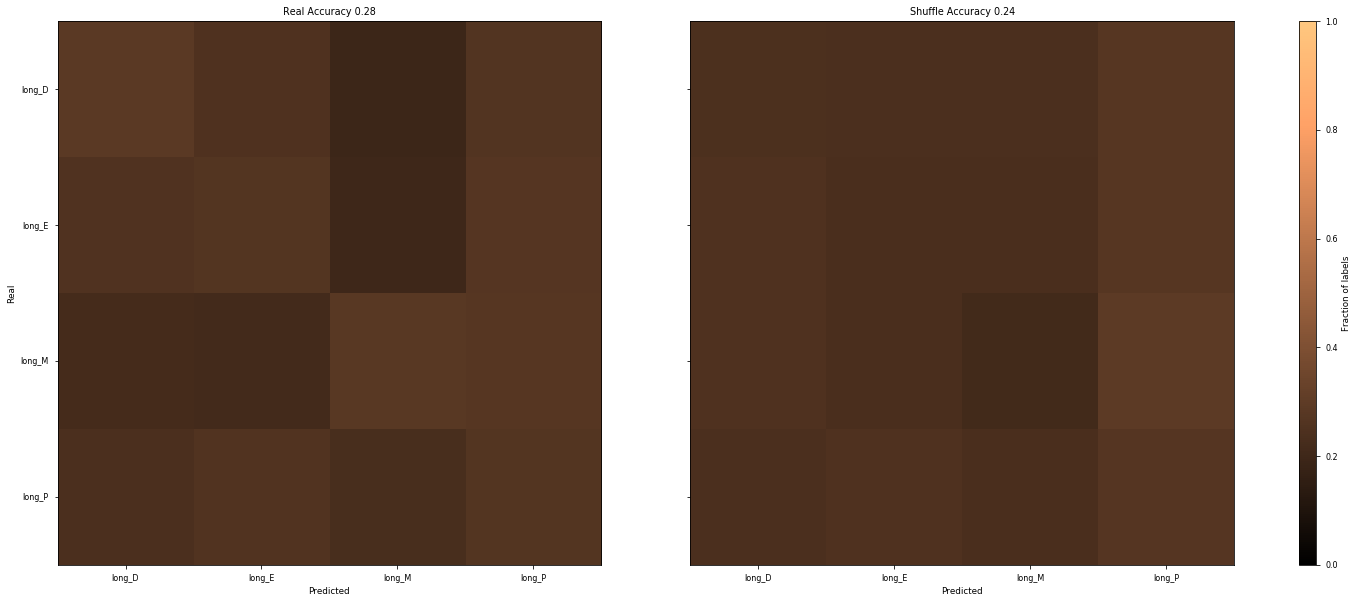

In [20]:
# plot confusion matrix
plot_cm(np.concatenate(out['y_true']),np.concatenate(out['y_pred']),
        np.concatenate(out['sy_true']),np.concatenate(out['sy_pred']),decoder+'_confusion')

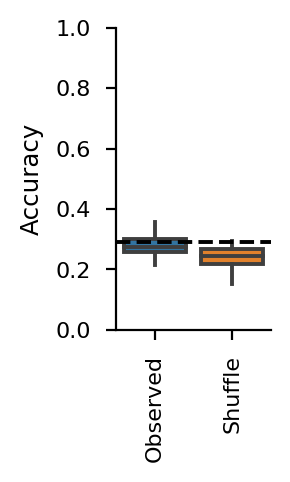

In [21]:
# plot accuracy
shuff_v=pd.DataFrame()
shuff_v['accuracy'] = out['acc']
shuff_v['shuff_accuracy'] = out['sacc']
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v, showfliers=False, showcaps=False, order=['accuracy', 'shuff_accuracy'])
plt.xticks(ticks=[0, 1], labels=['Observed', 'Shuffle'], rotation=90)
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shuff_accuracy'].quantile(.95), xmin=0, xmax=1, ls='--', c='k') #plot threshold for significance 
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [22]:
# is it significant?
loc = int(np.floor(len(shuff_v['shuff_accuracy'])*0.95))
a=np.argsort(shuff_v['shuff_accuracy'])
print('95th precentile of suffle is: ',shuff_v['shuff_accuracy'].quantile(.95)) # [a].to_numpy()[loc])
print('mean of decoding distribution is: ',np.mean(np.array(shuff_v['accuracy'])))
print ('mean shuffle accuracy is: ',np.mean(shuff_v['shuff_accuracy']))

95th precentile of suffle is:  0.2896174863387978
mean of decoding distribution is:  0.2763387978142076
mean shuffle accuracy is:  0.24043715846994537
